In [20]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchtext.data import Field, BucketIterator
from sklearn.model_selection import train_test_split, KFold
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import F1Score
import warnings

In [21]:
from utils import *

# Import data

In [22]:
FOLDS = 5 # number of folds for CV (== number of fusions tried)
SEED = 2022

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
# import data
data = import_data()

In [25]:
%%time
# preproc data
# proc
data.iloc[:, 0] = data.iloc[:, 0].apply(lambda x: x.replace("<br />", " ")) # remove break symbols
data.iloc[:, 0] = data.iloc[:, 0].apply(lambda x: x.lower()) # all lower case

# only use short sentences
data["len"] = data.iloc[:, 0].apply(lambda x: len(x.split()))
data = data[data["len"] < 256]

# tokenize data (split sentence into tokens)
tokenizer = Tokenizer()
print("Tokenizing the data...")
data["len"] = data.iloc[:, 0].apply(lambda x: len(tokenizer.tokenize(x)))

# only use short sentences
data = data[data["len"] < 256]

# dataset size
print("Length of the data : ", len(data))

# further proc
data.iloc[:, 0] = data.iloc[:, 0].apply(
    lambda row: re.sub("[^A-Za-z]+", " ", row)).apply(tokenizer.tokenize)

# reset index (we deleted some rows)
data = data.reset_index(drop=True)

Tokenizing the data...
Length of the data :  29544
CPU times: total: 3min 47s
Wall time: 3min 48s


In [39]:
%%time
# data split (CV)
datasets = []
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for i, (train_indices, test_indices) in enumerate(cv.split(data)):
    train_set, test_set = data.loc[train_indices, :], data.loc[test_indices, :]

    datasets.append((train_set, test_set))

CPU times: total: 15.6 ms
Wall time: 19.5 ms


In [40]:
# create data generators
def build_generators(train, test, device, batch_size=512):
    # build vocab
    vocab = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2}
    for item in train.iloc[:, 0]:
        for word in item:
            if word not in vocab:
                vocab[word] = len(vocab)
    pad_idx = vocab['__PAD__']
    voc_size = len(vocab)
    print("Vocabulary Size : ", voc_size)

    # create embedding
    embedding = torch.nn.Embedding(voc_size, 16)

    # dataframe to tensor
    train_y = torch.tensor(train.iloc[:, 1].values.astype(np.float32), device=device)
    test_y = torch.tensor(test.iloc[:, 1].values.astype(np.float32), device=device)

    unk_ID = vocab["__UNK__"]

    train_x_tensor = []
    for idx, text_corpus in enumerate(tqdm(train.iloc[:, 0])):
        foo = []
        for token in text_corpus:
            word_ID = vocab.get(token, unk_ID)
            foo.append(word_ID)
        while len(foo) < 256:
            foo.append(vocab["__PAD__"])
        train_x_tensor.append(foo)


    test_x_tensor = []
    for idx, text_corpus in enumerate(tqdm(test.iloc[:, 0])):
        foo = []
        for token in text_corpus:
            word_ID = vocab.get(token, unk_ID)
            foo.append(word_ID)
        while len(foo) < 256:
            foo.append(vocab["__PAD__"])
        test_x_tensor.append(foo)

    train_x = torch.tensor(train_x_tensor, device=device)
    test_x = torch.tensor(test_x_tensor, device=device)

    train = torch.utils.data.TensorDataset(train_x, train_y)
    test = torch.utils.data.TensorDataset(test_x, test_y)

    train_iterator = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = True)
    test_iterator = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle = True)

    # check imbalance
    check_imbalance(train_iterator, name='train set')
    check_imbalance(test_iterator, name='test set')

    print('Dataset initializing done')
    return train_iterator, test_iterator, voc_size, pad_idx, embedding

# CV

### Definition

In [41]:
LEARNING_RATE = 2e-4 # starting learning rate for scheduler

In [42]:
# template for training parent models (as we train them the same way)
def train_early_stopping(model_name: str, train_iter, valid_iter, embedding, pad_idx, voc_size, device, lr=2e-4, save=True):
    # init
    model = new_model(embedding, pad_idx, voc_size, device) # init model

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # train with early stopping
    history = train(model=model,
                    iterator=train_iter,
                    valid_iter=valid_iter,
                    optimizer=opt,
                    criterion=loss_fn,
                    epoch='unrestricted',
                    clip=1,
                    device=device)

    if save:
        # save model
        name = f'parallel_training/model{model_name}_IMDB_256'
        save_model(model, name=name)

        # save history
        name = f'parallel_training/history_model{model_name}_IMDB_256'
        save_history(history, name=name)

    return model

### Evaluation

In [43]:
scores = {'loss': {'A': [], 'B': [], 'vanilla_pre': [], 'vanilla_post': [], 'OT_pre': [], 'OT_post': [], 'random': []},
          'accuracy': {'A': [], 'B': [], 'vanilla_pre': [], 'vanilla_post': [], 'OT_pre': [], 'OT_post': [], 'random': []},
          'f1': {'A': [], 'B': [], 'vanilla_pre': [], 'vanilla_post': [], 'OT_pre': [], 'OT_post': [], 'random': []}}

Fold 1/5
Vocabulary Size :  23044


100%|██████████| 5908/5908 [00:00<00:00, 19275.73it/s]


Positive labels ratio (train set): 0.5019461837874429
Positive labels ratio (test set): 0.506093432633717
Dataset initializing done
Starting training for model A


Epoch: 92 - Train Loss: 0.1923 / Validation Loss: 0.4916 / Train acc: 0.9303 / Val acc: 0.8147 / Learning Rate : 0.0000:   0%|          | 92/1000000 [03:27<619:53:15,  2.23s/it]

Training has converged after 92 epochs (lr < 1e-06)


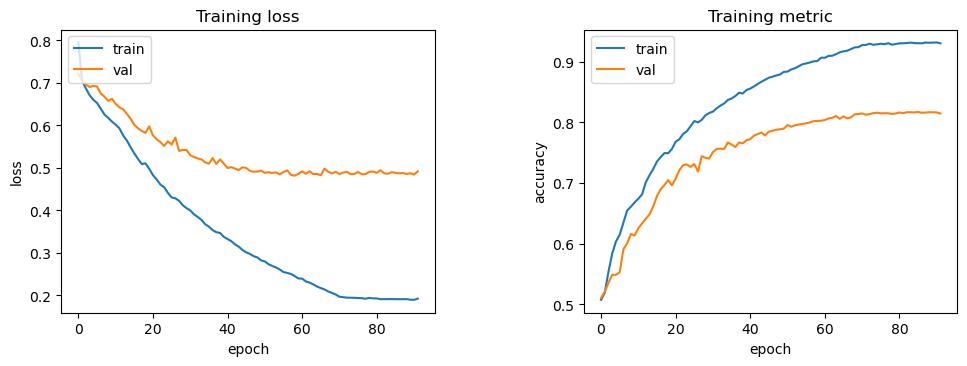

Epoch: 92 - Train Loss: 0.1923 / Validation Loss: 0.4916 / Train acc: 0.9303 / Val acc: 0.8147 / Learning Rate : 0.0000:   0%|          | 92/1000000 [03:27<627:09:52,  2.26s/it]


Starting training for model B


Epoch: 49 - Train Loss: 0.1525 / Validation Loss: 0.3942 / Train acc: 0.9467 / Val acc: 0.8496 / Learning Rate : 0.0000:   0%|          | 49/1000000 [01:48<609:43:23,  2.20s/it]

Training has converged after 49 epochs (lr < 1e-06)


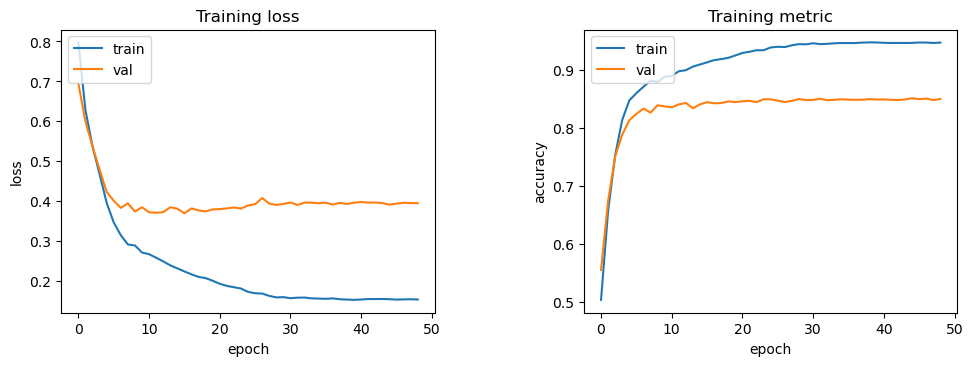

Epoch: 49 - Train Loss: 0.1525 / Validation Loss: 0.3942 / Train acc: 0.9467 / Val acc: 0.8496 / Learning Rate : 0.0000:   0%|          | 49/1000000 [01:48<614:51:33,  2.21s/it]


fusion successful
fusion successful
A loss: 0.4390118171771367 - accuracy: 0.8383930593297101 - f1: 0.8380162715911865
B loss: 0.39412374297777814 - accuracy: 0.8491588352958936 - f1: 0.8493567705154419
random loss: 0.7489441831906637 - accuracy: 0.5028329747886473 - f1: 0.5013540983200073
OT_pre loss: 0.5175257101655006 - accuracy: 0.7796672139190821 - f1: 0.7801286578178406
vanilla_pre loss: 0.8897175987561544 - accuracy: 0.6734412741545893 - f1: 0.6740013360977173
Starting retraining for model vanilla fusion


Epoch: 104 - Train Loss: 0.1878 / Validation Loss: 0.4393 / Train acc: 0.9394 / Val acc: 0.8127 / Learning Rate : 0.0000:   0%|          | 104/1000000 [03:39<585:07:45,  2.11s/it]

Training has converged after 104 epochs (lr < 1e-06)


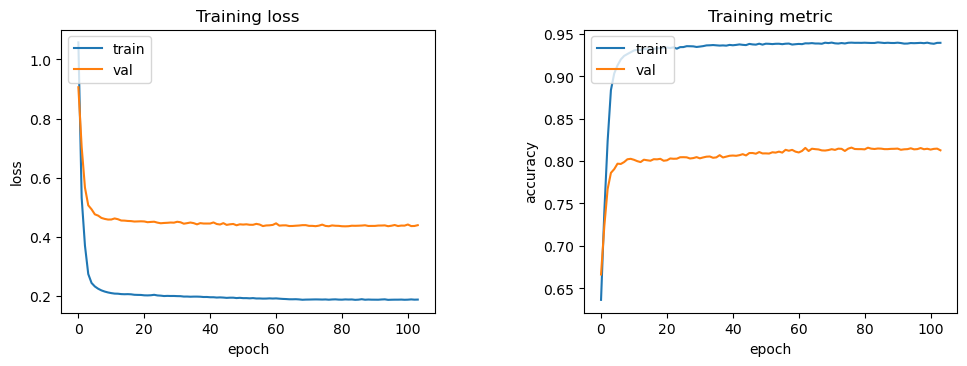

Epoch: 104 - Train Loss: 0.1878 / Validation Loss: 0.4393 / Train acc: 0.9394 / Val acc: 0.8127 / Learning Rate : 0.0000:   0%|          | 104/1000000 [03:40<587:50:17,  2.12s/it]


Starting retraining for model OT fusion


Epoch: 92 - Train Loss: 0.1937 / Validation Loss: 0.4391 / Train acc: 0.9396 / Val acc: 0.8073 / Learning Rate : 0.0000:   0%|          | 92/1000000 [03:14<593:17:40,  2.14s/it]

Training has converged after 92 epochs (lr < 1e-06)


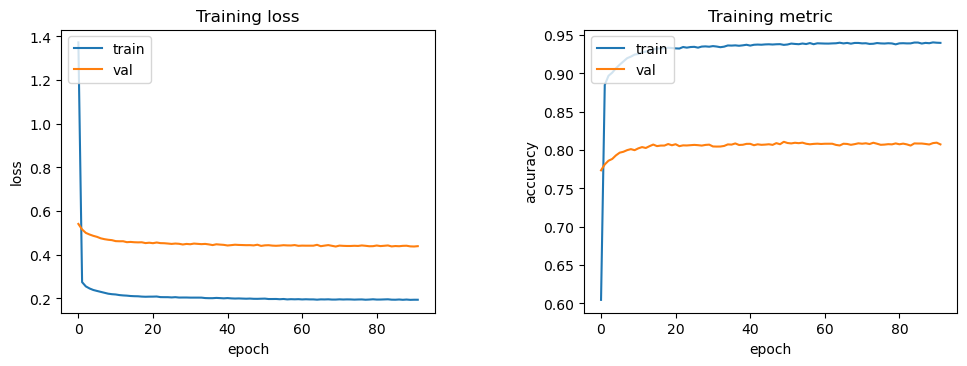

Epoch: 92 - Train Loss: 0.1937 / Validation Loss: 0.4391 / Train acc: 0.9396 / Val acc: 0.8073 / Learning Rate : 0.0000:   0%|          | 92/1000000 [03:14<588:07:58,  2.12s/it]


OT_post loss: 0.44017833719650906 - accuracy: 0.8077516417572463 - f1: 0.8078876733779907
vanilla_post loss: 0.434802549580733 - accuracy: 0.8141889341787439 - f1: 0.8131347298622131
Fold 2/5
Vocabulary Size :  23054


100%|██████████| 5909/5909 [00:00<00:00, 23402.00it/s]


Positive labels ratio (train set): 0.5059022635921303
Positive labels ratio (test set): 0.4902690810627856
Dataset initializing done
Starting training for model A


Epoch: 89 - Train Loss: 0.2008 / Validation Loss: 0.4815 / Train acc: 0.9246 / Val acc: 0.8081 / Learning Rate : 0.0000:   0%|          | 89/1000000 [03:15<612:02:36,  2.20s/it]

Training has converged after 89 epochs (lr < 1e-06)


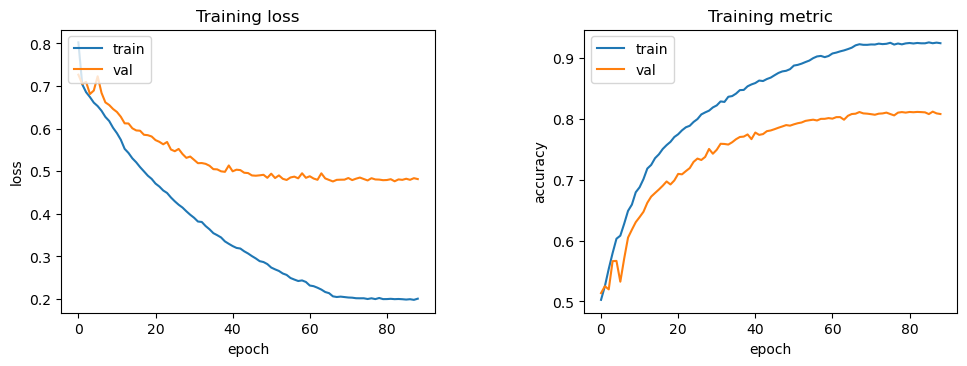

Epoch: 89 - Train Loss: 0.2008 / Validation Loss: 0.4815 / Train acc: 0.9246 / Val acc: 0.8081 / Learning Rate : 0.0000:   0%|          | 89/1000000 [03:15<609:32:52,  2.19s/it]


Starting training for model B


Epoch: 48 - Train Loss: 0.1730 / Validation Loss: 0.3913 / Train acc: 0.9381 / Val acc: 0.8403 / Learning Rate : 0.0000:   0%|          | 48/1000000 [01:45<606:36:09,  2.18s/it]

Training has converged after 48 epochs (lr < 1e-06)


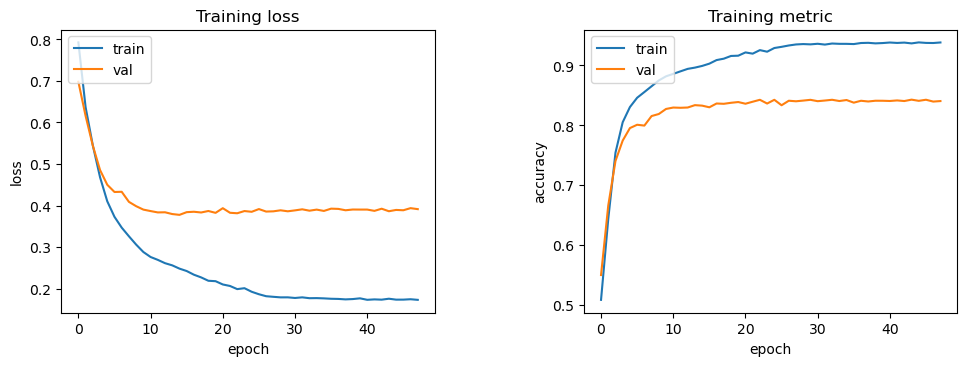

Epoch: 48 - Train Loss: 0.1730 / Validation Loss: 0.3913 / Train acc: 0.9381 / Val acc: 0.8403 / Learning Rate : 0.0000:   0%|          | 48/1000000 [01:45<611:02:18,  2.20s/it]


fusion successful
fusion successful
A loss: 0.434172123670578 - accuracy: 0.8349715139891696 - f1: 0.8341512680053711
B loss: 0.38913000375032425 - accuracy: 0.8420836153730444 - f1: 0.8412590622901917
random loss: 0.7416875958442688 - accuracy: 0.4965649913507822 - f1: 0.49822303652763367
OT_pre loss: 2.724246382713318 - accuracy: 0.5024931135303851 - f1: 0.501946210861206
vanilla_pre loss: 0.5608644187450409 - accuracy: 0.754272314041817 - f1: 0.7532577514648438
Starting retraining for model vanilla fusion


Epoch: 88 - Train Loss: 0.2173 / Validation Loss: 0.4432 / Train acc: 0.9264 / Val acc: 0.8039 / Learning Rate : 0.0000:   0%|          | 88/1000000 [03:04<580:40:54,  2.09s/it]

Training has converged after 88 epochs (lr < 1e-06)


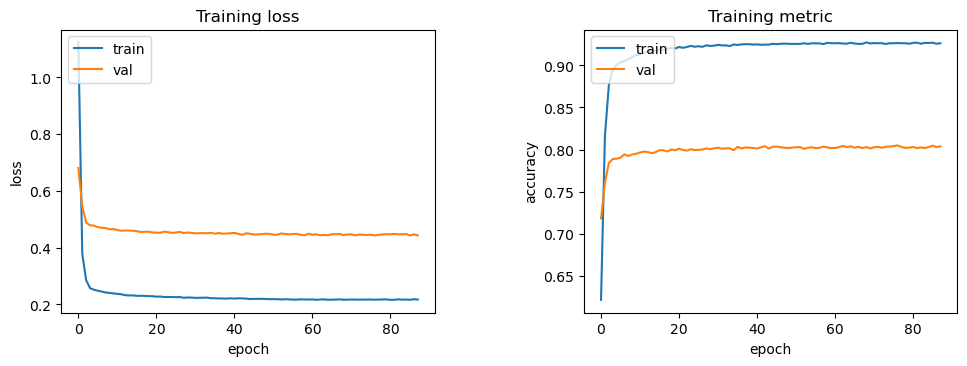

Epoch: 88 - Train Loss: 0.2173 / Validation Loss: 0.4432 / Train acc: 0.9264 / Val acc: 0.8039 / Learning Rate : 0.0000:   0%|          | 88/1000000 [03:05<584:16:17,  2.10s/it]


Starting retraining for model OT fusion


Epoch: 100 - Train Loss: 0.2233 / Validation Loss: 0.4462 / Train acc: 0.9219 / Val acc: 0.8033 / Learning Rate : 0.0000:   0%|          | 100/1000000 [03:30<580:12:51,  2.09s/it]

Training has converged after 100 epochs (lr < 1e-06)


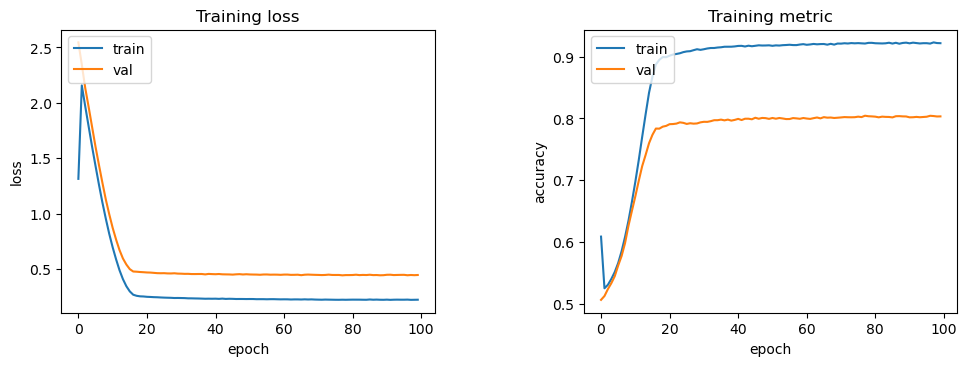

Epoch: 100 - Train Loss: 0.2233 / Validation Loss: 0.4462 / Train acc: 0.9219 / Val acc: 0.8033 / Learning Rate : 0.0000:   0%|          | 100/1000000 [03:30<583:50:44,  2.10s/it]


OT_post loss: 0.4464182381828626 - accuracy: 0.8029276897187124 - f1: 0.8028431534767151
vanilla_post loss: 0.4476178213953972 - accuracy: 0.8022766480520458 - f1: 0.8021661043167114
Fold 3/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 22130.87it/s]


Positive labels ratio (train set): 0.5016289401311614
Positive labels ratio (test set): 0.5073616517177187
Dataset initializing done
Starting training for model A


Epoch: 88 - Train Loss: 0.2011 / Validation Loss: 0.4959 / Train acc: 0.9222 / Val acc: 0.8089 / Learning Rate : 0.0000:   0%|          | 88/1000000 [03:13<608:01:31,  2.19s/it]

Training has converged after 88 epochs (lr < 1e-06)


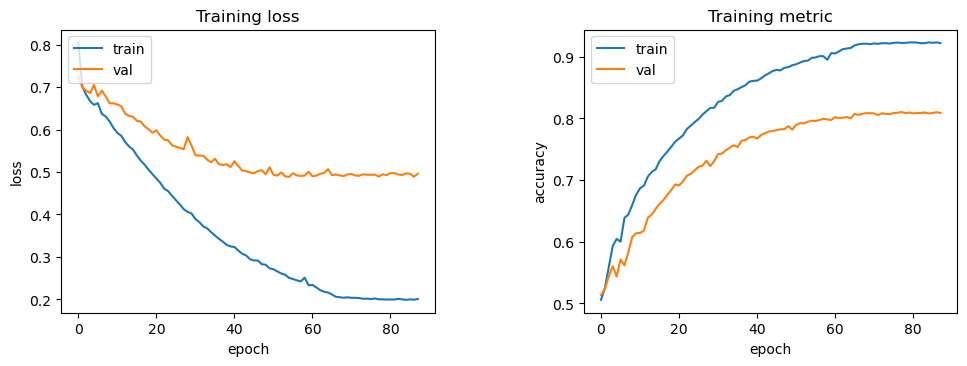

Epoch: 88 - Train Loss: 0.2011 / Validation Loss: 0.4959 / Train acc: 0.9222 / Val acc: 0.8089 / Learning Rate : 0.0000:   0%|          | 88/1000000 [03:13<610:54:26,  2.20s/it]


Starting training for model B


Epoch: 51 - Train Loss: 0.1532 / Validation Loss: 0.4259 / Train acc: 0.9459 / Val acc: 0.8385 / Learning Rate : 0.0000:   0%|          | 51/1000000 [01:51<615:28:12,  2.22s/it]

Training has converged after 51 epochs (lr < 1e-06)


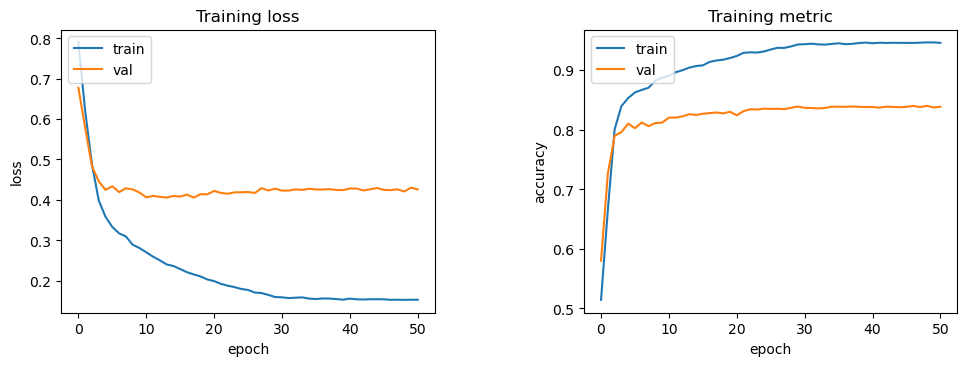

Epoch: 51 - Train Loss: 0.1532 / Validation Loss: 0.4259 / Train acc: 0.9459 / Val acc: 0.8385 / Learning Rate : 0.0000:   0%|          | 51/1000000 [01:52<610:54:20,  2.20s/it]


fusion successful
fusion successful
A loss: 0.4821915576855342 - accuracy: 0.8232727418020458 - f1: 0.8239973187446594
B loss: 0.4249117722113927 - accuracy: 0.839025834837545 - f1: 0.8392282724380493
random loss: 0.753730833530426 - accuracy: 0.4933685412906137 - f1: 0.49145370721817017
OT_pre loss: 0.9720877011617025 - accuracy: 0.6610799300541516 - f1: 0.6586562991142273
vanilla_pre loss: 1.3013781706492107 - accuracy: 0.5697178662755715 - f1: 0.5699779987335205
Starting retraining for model vanilla fusion


Epoch: 91 - Train Loss: 0.2048 / Validation Loss: 0.4550 / Train acc: 0.9331 / Val acc: 0.7988 / Learning Rate : 0.0000:   0%|          | 91/1000000 [03:10<581:18:58,  2.09s/it]

Training has converged after 91 epochs (lr < 1e-06)


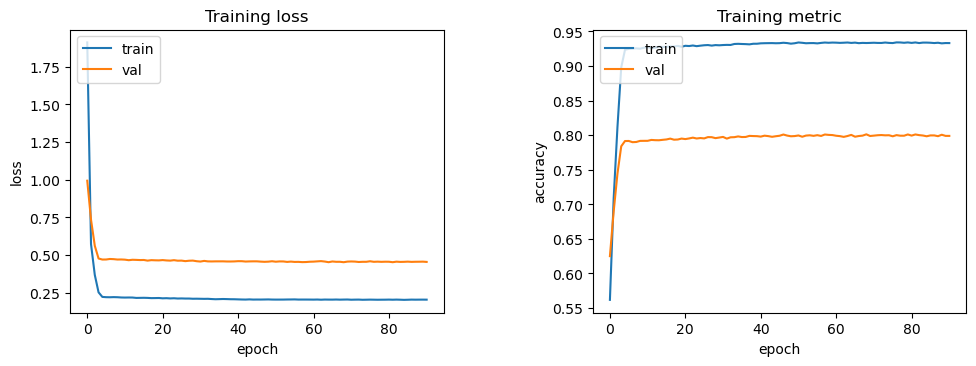

Epoch: 91 - Train Loss: 0.2048 / Validation Loss: 0.4550 / Train acc: 0.9331 / Val acc: 0.7988 / Learning Rate : 0.0000:   0%|          | 91/1000000 [03:11<583:04:43,  2.10s/it]


Starting retraining for model OT fusion


Epoch: 61 - Train Loss: 0.1950 / Validation Loss: 0.4448 / Train acc: 0.9351 / Val acc: 0.8081 / Learning Rate : 0.0000:   0%|          | 61/1000000 [02:07<581:45:12,  2.09s/it]

Training has converged after 61 epochs (lr < 1e-06)


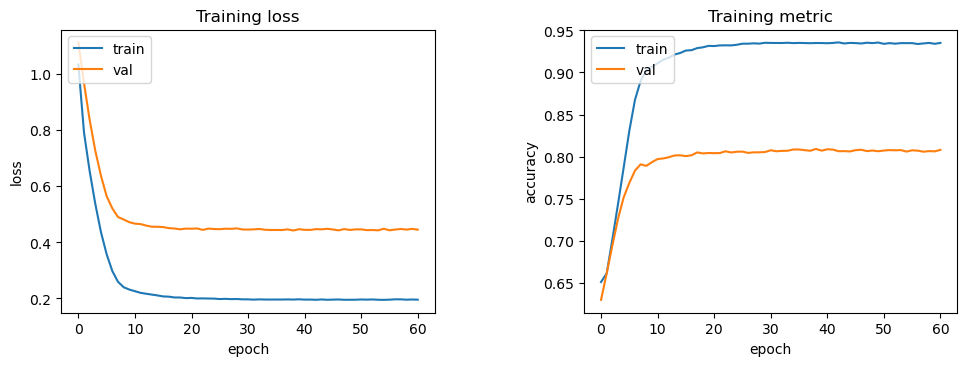

Epoch: 61 - Train Loss: 0.1950 / Validation Loss: 0.4448 / Train acc: 0.9351 / Val acc: 0.8081 / Learning Rate : 0.0000:   0%|          | 61/1000000 [02:08<583:36:51,  2.10s/it]


OT_post loss: 0.44365067034959793 - accuracy: 0.8081013556708784 - f1: 0.8070739507675171
vanilla_post loss: 0.45447850972414017 - accuracy: 0.8012900966456076 - f1: 0.8001353144645691
Fold 4/5
Vocabulary Size :  23075


100%|██████████| 5909/5909 [00:00<00:00, 21844.72it/s]


Positive labels ratio (train set): 0.5009519779987307
Positive labels ratio (test set): 0.5100693856828566
Dataset initializing done
Starting training for model A


Epoch: 88 - Train Loss: 0.2092 / Validation Loss: 0.5332 / Train acc: 0.9194 / Val acc: 0.7926 / Learning Rate : 0.0000:   0%|          | 88/1000000 [03:13<609:18:16,  2.19s/it]

Training has converged after 88 epochs (lr < 1e-06)


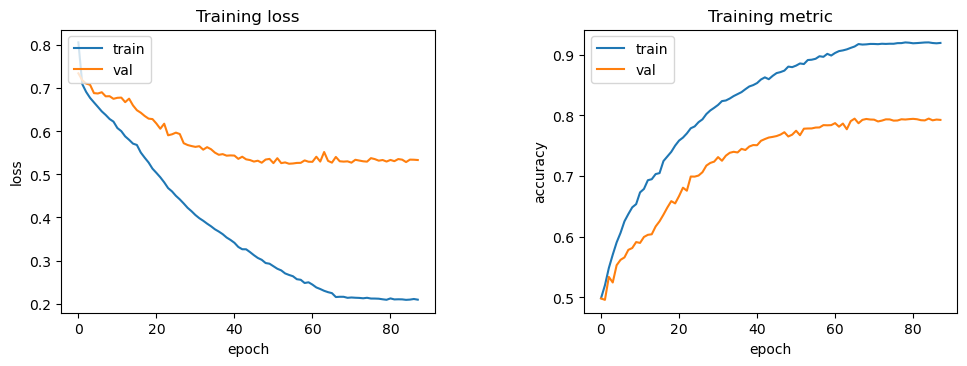

Epoch: 88 - Train Loss: 0.2092 / Validation Loss: 0.5332 / Train acc: 0.9194 / Val acc: 0.7926 / Learning Rate : 0.0000:   0%|          | 88/1000000 [03:13<610:10:36,  2.20s/it]


Starting training for model B


Epoch: 47 - Train Loss: 0.1779 / Validation Loss: 0.4593 / Train acc: 0.9342 / Val acc: 0.8203 / Learning Rate : 0.0000:   0%|          | 47/1000000 [01:43<604:38:37,  2.18s/it]

Training has converged after 47 epochs (lr < 1e-06)


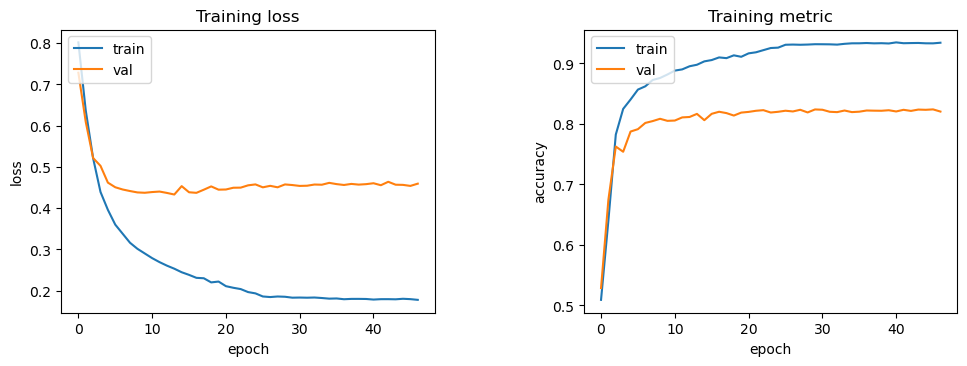

Epoch: 47 - Train Loss: 0.1779 / Validation Loss: 0.4593 / Train acc: 0.9342 / Val acc: 0.8203 / Learning Rate : 0.0000:   0%|          | 47/1000000 [01:43<610:17:15,  2.20s/it]


fusion successful
fusion successful
A loss: 0.48631208141644794 - accuracy: 0.8120076056708784 - f1: 0.8111355304718018
B loss: 0.4577415660023689 - accuracy: 0.8219606695622743 - f1: 0.8216280341148376
random loss: 0.7305068473021189 - accuracy: 0.5027892552271359 - f1: 0.5039770007133484
OT_pre loss: 2.425636649131775 - accuracy: 0.5233758038131768 - f1: 0.5239465236663818
vanilla_pre loss: 1.1328591754039128 - accuracy: 0.6131549197126955 - f1: 0.6131325364112854
Starting retraining for model vanilla fusion


Epoch: 69 - Train Loss: 0.2110 / Validation Loss: 0.4844 / Train acc: 0.9252 / Val acc: 0.7949 / Learning Rate : 0.0000:   0%|          | 69/1000000 [02:24<579:33:13,  2.09s/it]

Training has converged after 69 epochs (lr < 1e-06)


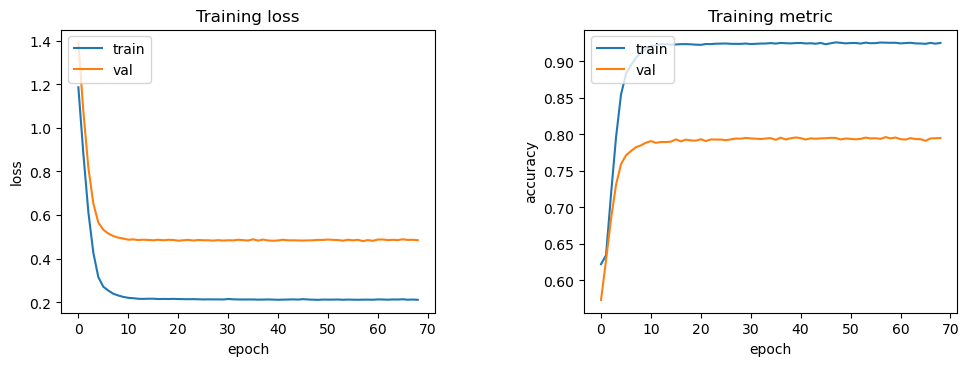

Epoch: 69 - Train Loss: 0.2110 / Validation Loss: 0.4844 / Train acc: 0.9252 / Val acc: 0.7949 / Learning Rate : 0.0000:   0%|          | 69/1000000 [02:24<582:58:15,  2.10s/it]


Starting retraining for model OT fusion


Epoch: 84 - Train Loss: 0.2277 / Validation Loss: 0.4947 / Train acc: 0.9187 / Val acc: 0.7871 / Learning Rate : 0.0000:   0%|          | 84/1000000 [03:01<596:05:37,  2.15s/it]

Training has converged after 84 epochs (lr < 1e-06)


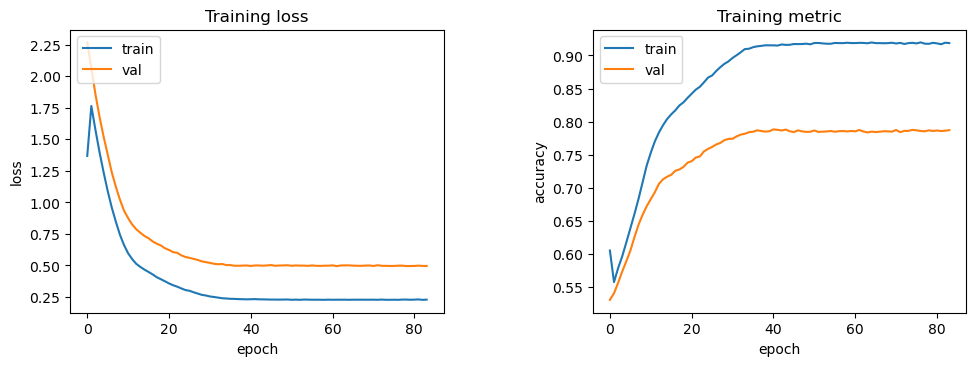

Epoch: 84 - Train Loss: 0.2277 / Validation Loss: 0.4947 / Train acc: 0.9187 / Val acc: 0.7871 / Learning Rate : 0.0000:   0%|          | 84/1000000 [03:01<599:43:59,  2.16s/it]


OT_post loss: 0.5018749460577965 - accuracy: 0.7838900092132972 - f1: 0.785919725894928
vanilla_post loss: 0.48486096660296124 - accuracy: 0.7935022751203369 - f1: 0.7921814322471619
Fold 5/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 20306.00it/s]


Positive labels ratio (train set): 0.503448275862069
Positive labels ratio (test set): 0.5000846166864106
Dataset initializing done
Starting training for model A


Epoch: 94 - Train Loss: 0.1743 / Validation Loss: 0.4908 / Train acc: 0.9369 / Val acc: 0.8146 / Learning Rate : 0.0000:   0%|          | 94/1000000 [03:31<622:53:50,  2.24s/it]

Training has converged after 94 epochs (lr < 1e-06)


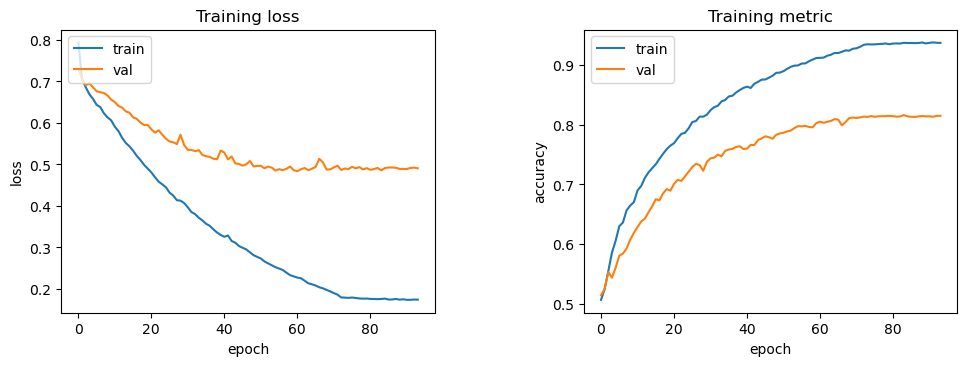

Epoch: 94 - Train Loss: 0.1743 / Validation Loss: 0.4908 / Train acc: 0.9369 / Val acc: 0.8146 / Learning Rate : 0.0000:   0%|          | 94/1000000 [03:32<626:38:40,  2.26s/it]


Starting training for model B


Epoch: 48 - Train Loss: 0.1523 / Validation Loss: 0.3980 / Train acc: 0.9475 / Val acc: 0.8476 / Learning Rate : 0.0000:   0%|          | 48/1000000 [01:46<616:56:49,  2.22s/it]

Training has converged after 48 epochs (lr < 1e-06)


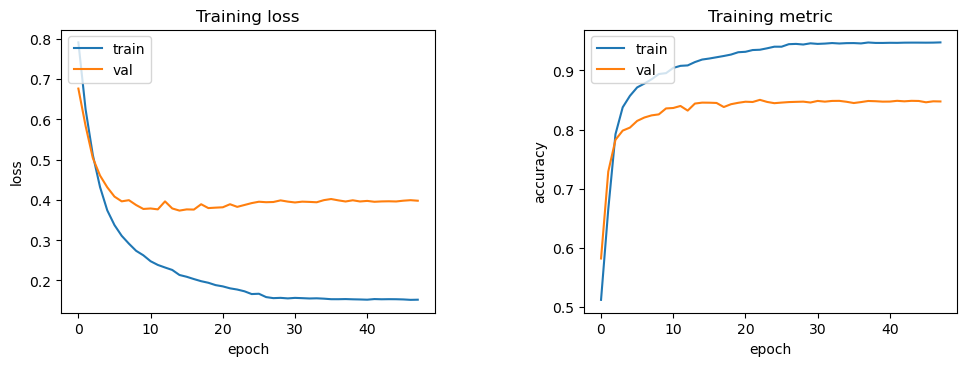

Epoch: 48 - Train Loss: 0.1523 / Validation Loss: 0.3980 / Train acc: 0.9475 / Val acc: 0.8476 / Learning Rate : 0.0000:   0%|          | 48/1000000 [01:47<620:12:16,  2.23s/it]


fusion successful
fusion successful
A loss: 0.4458998441696167 - accuracy: 0.836584428587545 - f1: 0.8366897702217102
B loss: 0.3981662020087242 - accuracy: 0.848870195923586 - f1: 0.8480284214019775
random loss: 0.750651071468989 - accuracy: 0.5068136093561973 - f1: 0.5060077905654907
OT_pre loss: 0.46629711737235385 - accuracy: 0.8039976778730444 - f1: 0.8016585111618042
vanilla_pre loss: 0.6856470902760824 - accuracy: 0.7226873918847773 - f1: 0.7241495847702026
Starting retraining for model vanilla fusion


Epoch: 109 - Train Loss: 0.1873 / Validation Loss: 0.4528 / Train acc: 0.9374 / Val acc: 0.8052 / Learning Rate : 0.0000:   0%|          | 109/1000000 [03:52<589:10:34,  2.12s/it]

Training has converged after 109 epochs (lr < 1e-06)


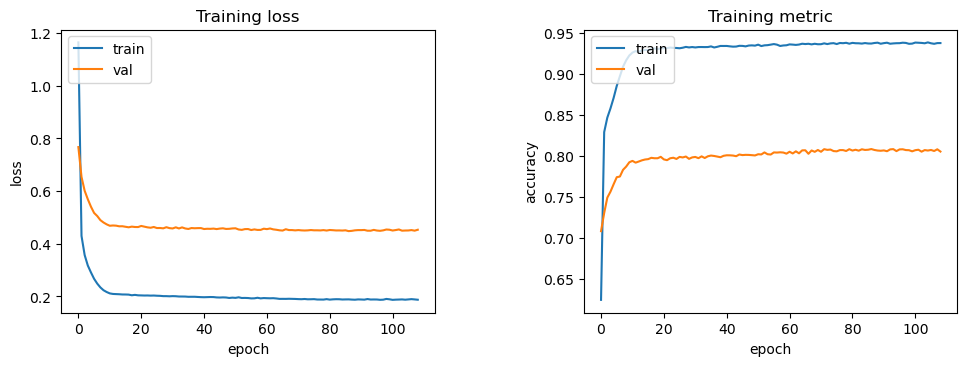

Epoch: 109 - Train Loss: 0.1873 / Validation Loss: 0.4528 / Train acc: 0.9374 / Val acc: 0.8052 / Learning Rate : 0.0000:   0%|          | 109/1000000 [03:52<592:31:10,  2.13s/it]


Starting retraining for model OT fusion


Epoch: 85 - Train Loss: 0.1932 / Validation Loss: 0.4460 / Train acc: 0.9367 / Val acc: 0.8083 / Learning Rate : 0.0000:   0%|          | 85/1000000 [03:11<659:15:01,  2.37s/it]

Training has converged after 85 epochs (lr < 1e-06)


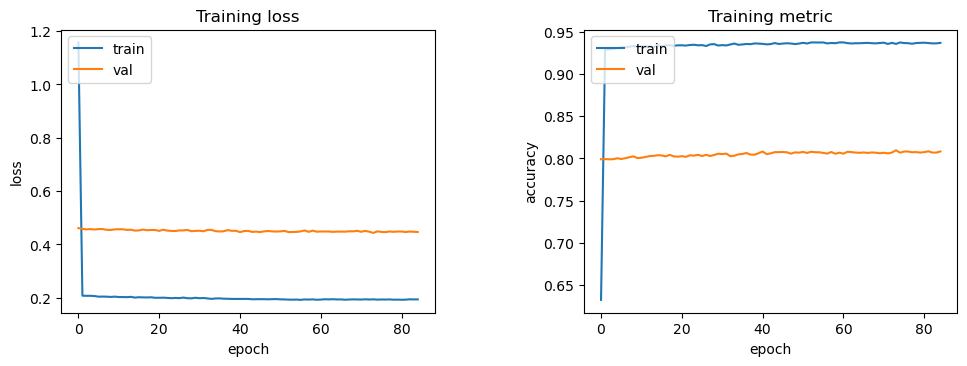

Epoch: 85 - Train Loss: 0.1932 / Validation Loss: 0.4460 / Train acc: 0.9367 / Val acc: 0.8083 / Learning Rate : 0.0000:   0%|          | 85/1000000 [03:12<627:48:51,  2.26s/it]


OT_post loss: 0.44579818348089856 - accuracy: 0.8074356244359207 - f1: 0.8072431683540344
vanilla_post loss: 0.4489762708544731 - accuracy: 0.807874548736462 - f1: 0.8074124455451965
CPU times: total: 57min 15s
Wall time: 57min 18s


In [44]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i in range(FOLDS):
        print(f'Fold {i + 1}/{FOLDS}')

        # get training, test set
        train_set, test_set = datasets.pop()

        # build generators
        train_iterator, test_iterator, voc_size, pad_idx, embedding = build_generators(train_set, test_set, device, batch_size=512)

        # train parent models
        print('Starting training for model A')
        modelA = train_early_stopping(model_name='A',
                                      train_iter=train_iterator,
                                      valid_iter=test_iterator,
                                      embedding=embedding,
                                      pad_idx=pad_idx,
                                      voc_size=voc_size,
                                      device=device,
                                      lr=LEARNING_RATE,
                                      save=False)
        print('Starting training for model B')
        modelB = train_early_stopping(model_name='B',
                                      train_iter=train_iterator,
                                      valid_iter=test_iterator,
                                      embedding=embedding,
                                      pad_idx=pad_idx,
                                      voc_size=voc_size,
                                      device=device,
                                      lr=LEARNING_RATE,
                                      save=False)

        # model fusion
        # 1) vanilla
        model_fusion_vanilla = vanilla_fusion(modelA=modelA, modelB=modelB, pad_idx=pad_idx, voc_size=voc_size, embedding=embedding, device=device)
        # 2) optimal transport
        model_fusion = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size, device, fusion_ratio=0.5)

        # evaluate
        # ensure all models on same device
        modelA = modelA.to(device)
        modelB = modelB.to(device)
        model_random = new_model(embedding, pad_idx, voc_size, device)
        model_fusion = model_fusion.to(device)
        model_fusion_vanilla = model_fusion_vanilla.to(device)

        # test models
        scoresA = validation(modelA, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)
        scoresB = validation(modelB, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)
        scores_random = validation(model_random, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)
        scores_fusion = validation(model_fusion, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)
        scores_fusion_vanilla = validation(model_fusion_vanilla, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

        # put into cpu
        for name, scores_ in zip(('A', 'B', 'random', 'OT_pre', 'vanilla_pre'), (scoresA, scoresB, scores_random, scores_fusion, scores_fusion_vanilla)):
            loss, acc, f1 = scores_

            loss = loss.to('cpu') if isinstance(loss, torch.Tensor) else loss
            acc = acc.to('cpu') if isinstance(acc, torch.Tensor) else acc
            f1 = f1.to('cpu') if isinstance(f1, torch.Tensor) else f1

            print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

        # retraining
        # 1) vanilla
        # train with early stopping
        print('Starting retraining for model vanilla fusion')
        train(model=model_fusion_vanilla,
              iterator=train_iterator,
              valid_iter=test_iterator,
              optimizer=torch.optim.SGD(model_fusion_vanilla.parameters(), lr=LEARNING_RATE),
              criterion=nn.CrossEntropyLoss(),
              epoch='unrestricted',
              clip=1,
              device=device)
        # 2) optimal transport
        # train with early stopping (+ 0.5 of normal learning rate -> works?)
        print('Starting retraining for model OT fusion')
        train(model=model_fusion,
              iterator=train_iterator,
              valid_iter=test_iterator,
              optimizer=torch.optim.SGD(model_fusion.parameters(), lr=LEARNING_RATE / 2),
              criterion=nn.CrossEntropyLoss(),
              epoch='unrestricted',
              clip=1,
              device=device)

        # evaluate
        # ensure all models on same device
        model_fusion = model_fusion.to(device)
        model_fusion_vanilla = model_fusion_vanilla.to(device)

        # test models
        scores_fusion = validation(model_fusion, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)
        scores_fusion_vanilla = validation(model_fusion_vanilla, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

        # put into cpu
        for name, scores_ in zip(('OT_post', 'vanilla_post'), (scores_fusion, scores_fusion_vanilla)):
            loss, acc, f1 = scores_

            loss = loss.to('cpu') if isinstance(loss, torch.Tensor) else loss
            acc = acc.to('cpu') if isinstance(acc, torch.Tensor) else acc
            f1 = f1.to('cpu') if isinstance(f1, torch.Tensor) else f1

            print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

### Export as LaTeX

In [45]:
df = pd.DataFrame.from_dict(scores)

In [46]:
# entries like: mean +- std
n_rows, n_cols = df.shape
for row in range(n_rows):
    df.iloc[row, 0] = str(np.round(np.mean(df.iloc[row, 0]), 3)) + ' ± ' + str(np.round(np.std(df.iloc[row, 0]), 3)) # loss
    df.iloc[row, 1] = str(np.round(np.mean(df.iloc[row, 1]), 3)) + ' ± ' + str(np.round(np.std(df.iloc[row, 1]), 3)) # accuracy
    df.iloc[row, 2] = str(np.round(np.mean(df.iloc[row, 2]), 3)) + ' ± ' + str(np.round(np.std(df.iloc[row, 2]), 3)) # f1

In [47]:
# rename rows, cols
df.columns = ['Loss', 'Accuracy', 'F1 score']
df.index = ['Model A', 'Model B', 'Vanilla', 'Vanilla (retraining)', 'Optimal transport', 'Optimal transport (retraining)', 'Untrained model (baseline)']

In [48]:
# boldify highest score
for col in (0, 1, 2):
    if col == 0:
        index_max = np.argmin([float(entry.split('±')[0]) for entry in df.iloc[:, col]])
    else:
        index_max = np.argmax([float(entry.split('±')[0]) for entry in df.iloc[:, col]])
    entry = df.iloc[index_max, col]
    entry = 'BOLD{' + entry + '}'
    df.iloc[index_max, col] = entry

In [49]:
# convert to latex
latex = df.to_latex(index=True,
                    bold_rows=True,
                    caption='Model performance (5-fold CV)',
                    position='H').replace('BOLD\\', r'\textbf').replace('\}', '}')

C:\Users\jjung\AppData\Local\Temp\ipykernel_14260\1498540714.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(index=True,


In [50]:
# print as latex
print(latex)

\begin{table}[H]
\centering
\caption{Model performance (5-fold CV)}
\begin{tabular}{llll}
\toprule
{} &                 Loss &           Accuracy &           F1 score \\
\midrule
\textbf{Model A                       } &        0.458 ± 0.022 &       0.829 ± 0.01 &       0.829 ± 0.01 \\
\textbf{Model B                       } &  \textbf{0.413 ± 0.026} &  \textbf{0.84 ± 0.01} &  \textbf{0.84 ± 0.01} \\
\textbf{Vanilla                       } &        0.914 ± 0.274 &      0.667 ± 0.068 &      0.667 ± 0.068 \\
\textbf{Vanilla (retraining)          } &        0.454 ± 0.017 &      0.804 ± 0.007 &      0.803 ± 0.007 \\
\textbf{Optimal transport             } &        1.421 ± 0.963 &      0.654 ± 0.125 &      0.653 ± 0.125 \\
\textbf{Optimal transport (retraining)} &        0.456 ± 0.023 &      0.802 ± 0.009 &      0.802 ± 0.008 \\
\textbf{Untrained model (baseline)    } &        0.745 ± 0.008 &        0.5 ± 0.005 &        0.5 ± 0.005 \\
\bottomrule
\end{tabular}
\end{table}



In [38]:
# save as latex (in text format)
with open('./Output/scores_different_seeds.txt','w') as dat:
    dat.write(str(latex))